# Sketch for a possible solution of the homework
The solution below is only one of the many possible ways in which one could solve the homework.   It attempts to be simple and uncomplicated.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.feature
import skimage.transform
import pathlib
import numpy as np

The code below, for ease of explanation, operates on a single image. A separate notebook uses the same code to operate on all images in the directory and save results for each, as required in the homework text.

In [2]:
ddir = pathlib.Path("homework images vol 2")
fns = list(ddir.glob("*.jpg"))
fn = fns[0]

The approach suggested in the homework text suggested the following steps.  We now go through them in succession.
* Load the image and resize it to a manageable size. You may want to convert it to grayscale.
* Look for edges using the Canny edge detector.
* Look for four long straight lines using the Hough line detector.
* The intersections between pairs of these lines should correspond to the corners of the paper sheet (note: 4 lines define 6 different intersections!)
* Once you have the four corners of the sheet, you can obtain a straightened version of your sheet of paper, by a geometric transformation.
* Binarize and find connected components (this might be tricky when illumination is uneven. How to fix that?).
* Cut a square bounding box around each connected component.
* Resize that to a 28x28 and classify it using a convnet trained on the MNIST dataset.

## Load the image and resize it to a manageable size. You may want to convert it to grayscale.

Note we also convert it to float, so the range is 0.0 (black) to 1.0 (white)

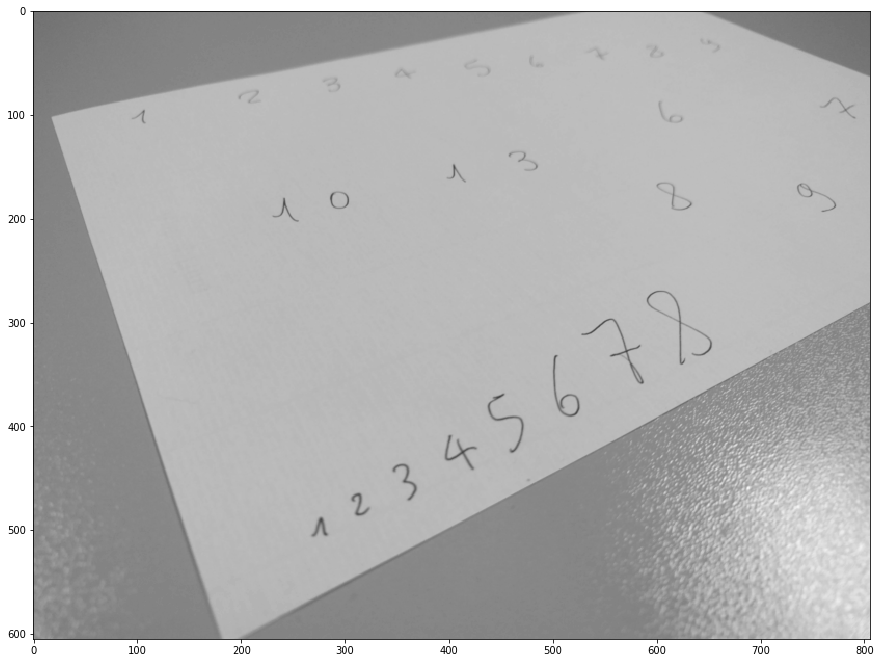

In [3]:
im = skimage.io.imread(fn)
im = skimage.img_as_float(skimage.color.rgb2gray(im))
im = skimage.transform.rescale(im, scale=0.2, multichannel=False)
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(im, cmap="gray", vmin=0, vmax=1)

## Look for edges using the Canny edge detector
The parameters below (sigma, low_threshold, high_threshold) are best chosen by testing many images at once.  The setting below is probably not optimal but works well enough.

**Important**: 5 is a quite large value for sigma.  It helps a lot in this case, and is especially useful to avoid detecting the thin but prominent lines between tiles that you can see in some images (eg `IMG_20190312_183855.jpg`).  It is important you understand why a large value of sigma helps in this case.

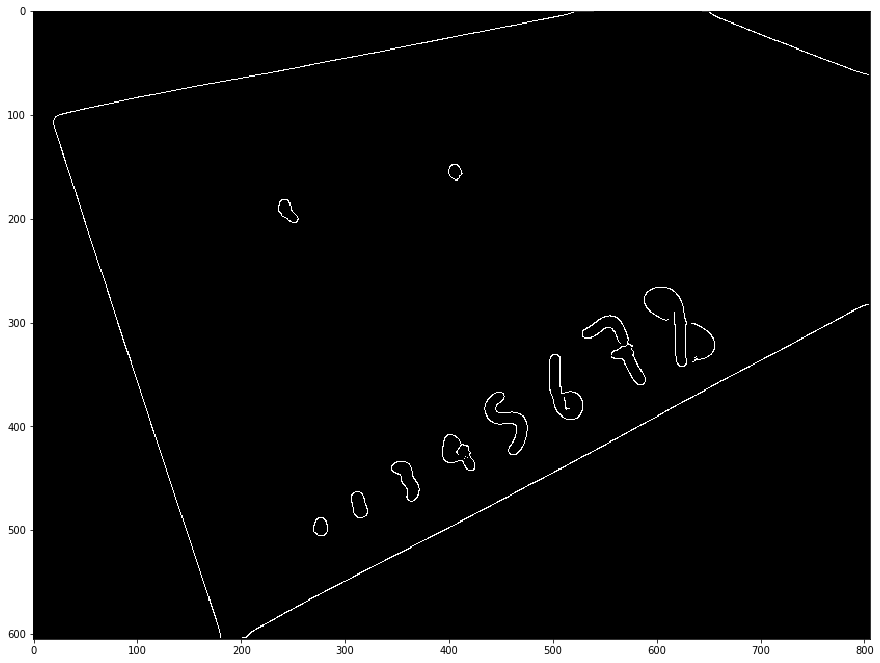

In [4]:
edges = skimage.feature.canny(im, sigma = 5, low_threshold=0.001, high_threshold=0.050)
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(edges, cmap="gray", vmin=0, vmax=1)

## Look for four long straight lines using the Hough line detector.
We just look for the four longest straight lines in the resulting edge image.  We ask `hough_line_peaks` to return the 4 largest peaks.

In [5]:
H, angles, dists = skimage.transform.hough_line(edges)
accum, angles, dists = skimage.transform.hough_line_peaks(
    H, angles, dists, min_distance=20, min_angle=15, threshold=10, num_peaks=4
)

## The intersections between pairs of these lines should correspond to the corners of the paper sheet (note: 4 lines define 6 different intersections!)

How do we decide which of the 6 intersections to keep?  A simplistic (but reasonable) solution is to keep the 4 intersections that are closest to the center of the image.

In [6]:
# Some useful functions

def drawline(ax, angle, dist):
    """Draws a line on the image given its hough representation (angle, distance)"""
    p1 = np.array([dist * np.cos(angle), dist * np.sin(angle)])
    # This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
    linedir = np.array([np.cos(angle + np.pi / 2), np.sin(angle + np.pi / 2)])
    # These are two points very far away in two opposite directions along the line
    p0 = p1 - linedir * 1000
    p2 = p1 + linedir * 1000
    # We now draw a line through p0 and p2, without rescaling the axes.
    ax.plot([p0[0], p2[0]], [p0[1], p2[1]], scalex=False, scaley=False, color="b")


def angledist2homogeneous(angle, dist):
    """Returns the homogeneous coordinates representation of a line given its hough representation,
       as a vector of 3 elements"""
    p1 = np.array([dist * np.cos(angle), dist * np.sin(angle)])
    linedir = np.array([np.cos(angle + np.pi / 2), np.sin(angle + np.pi / 2)])
    p2 = p1 + linedir
    return np.cross(np.append(p1, 1), np.append(p2, 1))


def intersect(angle1, dist1, angle2, dist2):
    """Intersects two lines given their hough representations;
       returns the cartesian coordinates of the intersection point.
       Could be well outside of the image """
    l1 = angledist2homogeneous(angle1, dist1)
    l2 = angledist2homogeneous(angle2, dist2)
    p = np.cross(l1, l2)
    return (p / p[2])[:2]

found 6 intersections
Kept the 4 intersections closest to the center of the image


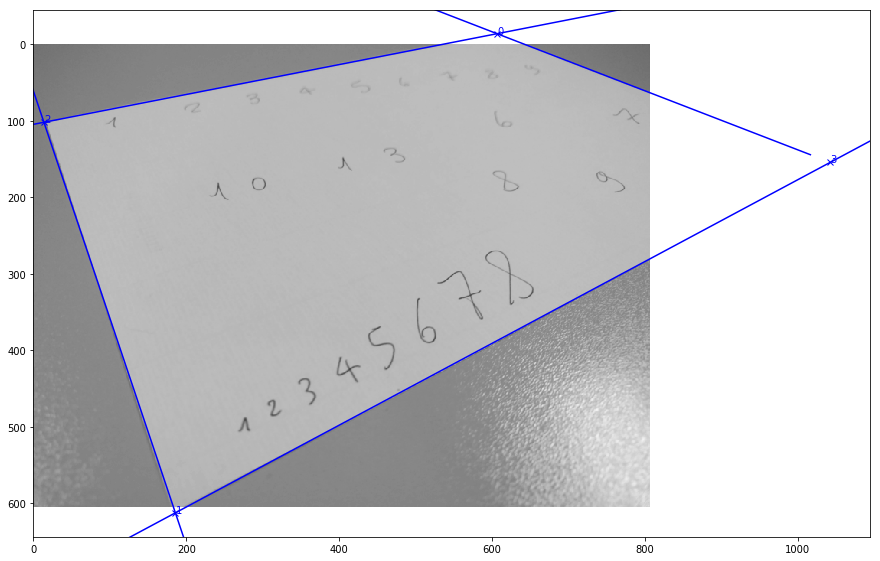

In [7]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(im, cmap="gray", vmin=0, vmax=1)

import itertools
intersections = []
for (angle1,dist1),(angle2,dist2) in itertools.combinations(zip(angles,dists), 2):
    p = intersect(angle1, dist1, angle2, dist2)
    intersections.append(p)
print(f"found {len(intersections)} intersections")
    
def distance_from_center(p):
    center = np.array([im.shape[1]/2, im.shape[0]/2])
    return np.linalg.norm(p-center)

intersections = sorted(intersections, key=distance_from_center)
intersections = intersections[:4]
print(f"Kept the {len(intersections)} intersections closest to the center of the image")

for i,p in enumerate(intersections):
    ax.plot(p[0], p[1], 'bx')
    ax.text(p[0], p[1], f"{i}", color="blue")
    
for angle,dist in zip(angles,dists):
    drawline(ax, angle, dist)

Note that the 4 points in the list `intersections` could appear in any order (e.g. points 0 and 1 might be the top left and bottom right, respectively).  For our convenience, it's useful if instead they appear in a predictable order, and we could decide that this order is counterclockwise (so that the edges of the sheet of paper are given by joining points 0-1, 1-2, 2-3 and 3-0.

To do this, we compute in `ref` the coordinates of a point in the middle of the sheet. We obtain those as the barycenter of the 4 corners.  Then, we compute the angle of each corner wrt `ref`, and we sort the points with increasing angle.

Note that we don't yet try to know which is the short or long side of the sheet, nor which is the "bottom" of the paper.

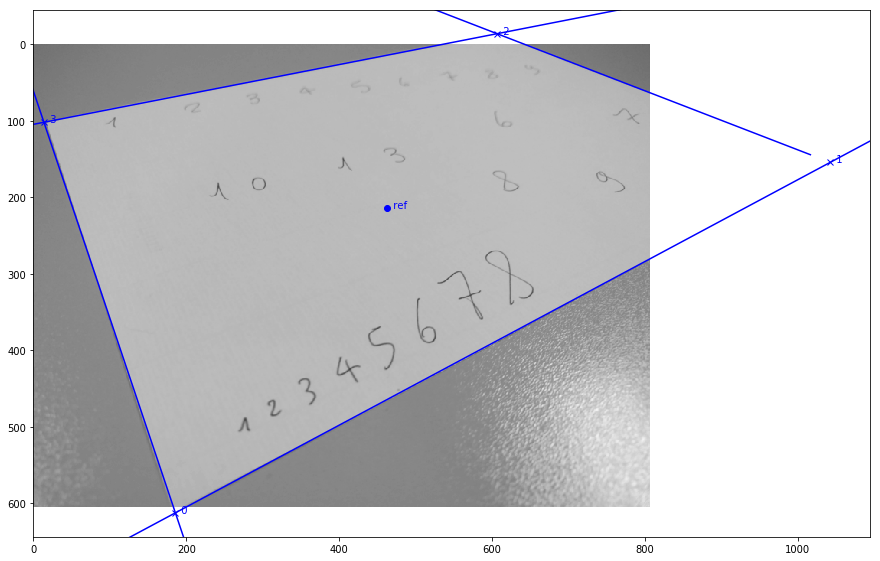

In [8]:
def angle_wrt_ref(p, ref):
    """ Compute the angle of the vector between ref and p.
    This is 0 if p is on the right of ref.
    +pi/2 if p is at the bottom of ref. 
    -pi/2 if p is at the top of ref.
    (this is due to the fact that y coordinates increase moving from top to bottom of the image)"""
    vec = p - ref
    return np.arctan2(vec[1],vec[0])

ref = np.mean(np.array(intersections), axis=0)
intersections = sorted(intersections, key=lambda p: -1*angle_wrt_ref(p, ref))

fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(im, cmap="gray", vmin=0, vmax=1)

ax.plot(ref[0], ref[1], 'bo')
ax.text(ref[0], ref[1], "  ref", color="blue")

for i,p in enumerate(intersections):
    ax.plot(p[0], p[1], 'bx')
    ax.text(p[0], p[1], f"  {i}", color="blue")
    
for angle,dist in zip(angles,dists):
    drawline(ax, angle, dist)

Let's now name these vertices `a`, `b`, `c` and `d`.  We decide that the short edge of the paper is `ab` and the long edge `bc`.  We expect something like this:

```
d ------ c
|        |
|        |
|        |
|        |
a ------ b

```

We map points 0,1,2,3 to a,b,c,d.  Unless it turns out that `ab` is longer than `bc` (in the image), then we shift by one so `ab` is the shorter edge.  This is not a perfect method and might occasionally fail if the image is very slanted.

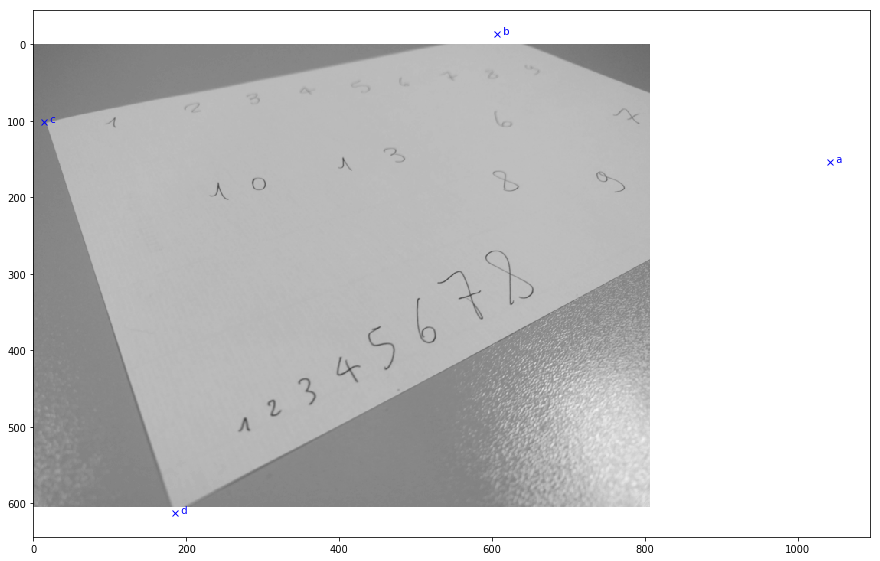

In [9]:
from numpy.linalg import norm

a, b, c, d = intersections

if norm(a - b) + norm(c - d) > norm(b - c) + norm(d - a):
    a, b, c, d = b, c, d, a

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(im, cmap="gray", vmin=0, vmax=1)

for letter, p in zip("abcd", (a, b, c, d)):
    ax.plot(p[0], p[1], "bx")
    ax.text(p[0], p[1], f"  {letter}", color="blue")

## Once you have the four corners of the sheet, you can obtain a straightened version of your sheet of paper, by a geometric transformation

Then, we map a,b,c,d to points at the corresponding corners of a rectangle A,B,C,D with the dimensions of a sheet of A4 paper (AB being the short edge), and transform the image accordingly.

```
D ------ C
|        |
|        |
|        |
|        |
A ------ B

```

In the resulting transformed image (`tim`) we can decide how many pixels per millimiter we want (`px_per_mm`).  This is useful in the following.

Note: from now on, we are not yet sure that the text is in the correct orientation. That's OK, we will fix that later.

Note that by setting `mode='edge'` in `skimage.transform.warp`, we are filling any area of the sheet which is out of the image with the color of the closest pixel which is in the image.  This "magically", in most cases, gives a white sheet even if the sheet is partly out of the image.

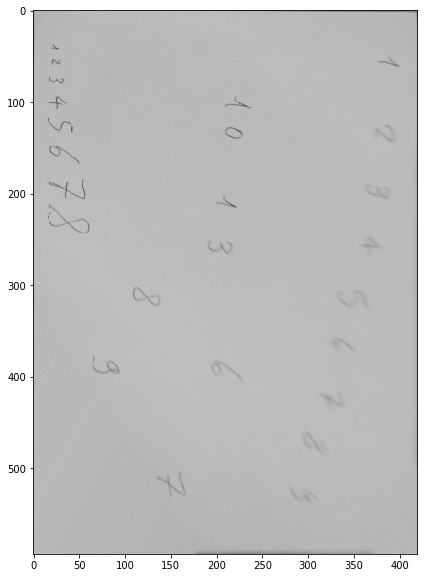

In [10]:
px_per_mm = 2
w, h = 210 * px_per_mm, 297 * px_per_mm
A = np.array([0, h])
B = np.array([w, h])
C = np.array([w, 0])
D = np.array([0, 0]) # remember that y=0 is at the top, so D is at 0,0

tf = skimage.transform.estimate_transform(
    "projective", src=np.vstack((a, b, c, d)), dst=np.vstack((A, B, C, D))
)

tim = skimage.transform.warp(
    image=im, inverse_map=tf.inverse, output_shape=(h, w), mode="edge"
)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(tim, cmap="gray", vmin=0, vmax=1)

## Binarize and find connected components (this might be tricky when illumination is uneven. How to fix that?)

Ideally, to aid binarization we want the sheet to be as close as possible to white (intensity close to 1.0) and the text to be as dark as possible (intensity close to 0.0).
However, in some images the sheet is significantly darker than 1.0, and also has a non-uniform intensity.

We can try to find the background intensity for every pixel.

One possible solution: the sheet is bright, the text is dark and thin.  So we compute the background color by a grayscale dilation using as a structuring element a disk with 5mm of radius: this is the same as substituting each pixel with the brightest pixel in a range of 5mm. This should make disappear any dark mark thinner than 10mm.

Once we have the background, we divide the image by the background; then, pixels that were close to the background intensity in the image will be close to 1.0.  Pixels that were dark (close to 0) will still be dark.  This is just one way to do it. Another option would have been to subtract the background and then add 1.0.

Once we have this image, we can threshold it to obtain a binary image with True digits on a False background. Because some digits might be formed by several disconnected segments, we dilate the resulting binary mask to make sure we have one connected component per digit.

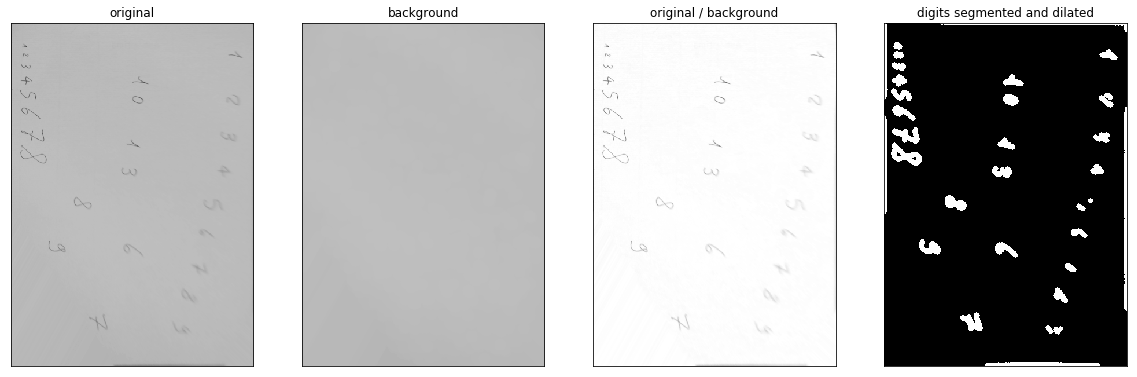

In [11]:
bg = skimage.morphology.dilation(tim, skimage.morphology.disk(5 * px_per_mm))
tim2 = tim / bg
tim3 = tim2 < 0.90
tim4 = skimage.morphology.dilation(tim3, skimage.morphology.disk(2 * px_per_mm))
fig, axs = plt.subplots(ncols=4, figsize=(20, 10))
axs[0].imshow(tim, cmap="gray", vmin=0, vmax=1)
axs[0].set(title="original")
axs[1].imshow(bg, cmap="gray", vmin=0, vmax=1)
axs[1].set(title="background")
axs[2].imshow(tim2, cmap="gray", vmin=0, vmax=1)
axs[2].set(title="original / background")
axs[3].imshow(tim4, cmap="gray", vmin=0, vmax=1)
axs[3].set(title="digits segmented and dilated")
for ax in axs:
    ax.set(xticks=[], yticks=[])

Now we can compute connected components and find their bounding boxes.  We discard all connected components that are too small, too large, or too elongated to be a proper digit.

## Cut a square bounding box around each connected component

Then, for every accepted connected component we find the largest dimension `dim` and paste the digit (cut from the grayscale image `tim2`, not from the binary mask we used to compute connected components!) at the center of a white square with `dim` rows and `dim` columns.  Then we resize that to 28x28.

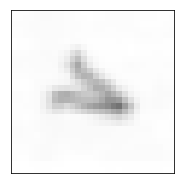

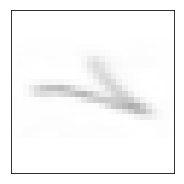

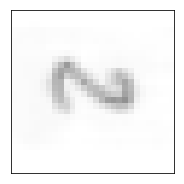

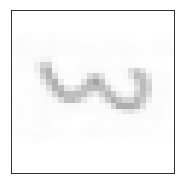

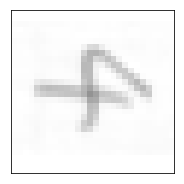

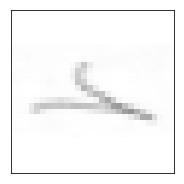

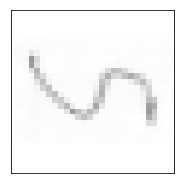

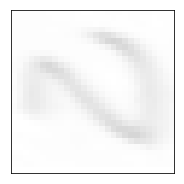

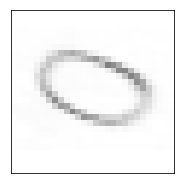

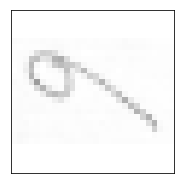

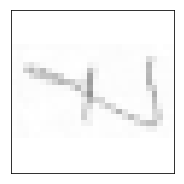

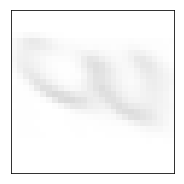

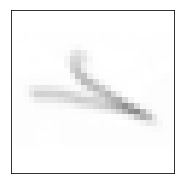

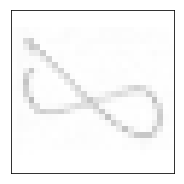

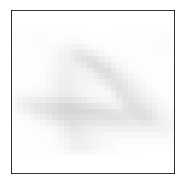

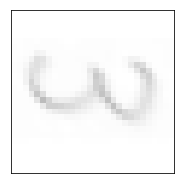

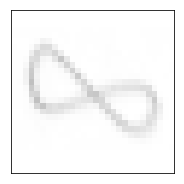

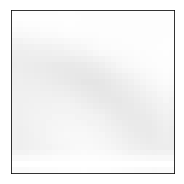

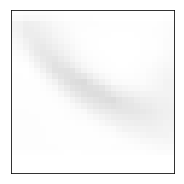

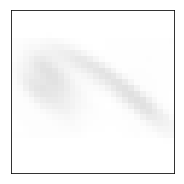

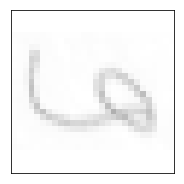

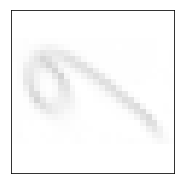

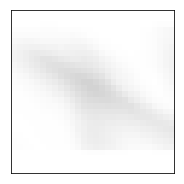

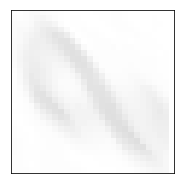

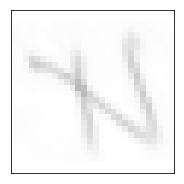

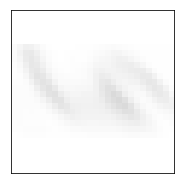

In [12]:
import skimage.measure

regions = skimage.measure.regionprops(skimage.morphology.label(tim4))

def goodregion(r):
    w = (r.bbox[3] - r.bbox[1] + 1) / px_per_mm
    h = (r.bbox[2] - r.bbox[0] + 1) / px_per_mm
    if w < 5 or w > 120:
        return False
    if h < 5 or h > 120:
        return False
    if w / h > 4 or w / h < 1/4:
        return False
    return True

digits = []
for r in regions:
    if goodregion(r):
        digit = tim2[r.bbox[0]:r.bbox[2],r.bbox[1]:r.bbox[3]]
        dim = max(digit.shape)
        sq_digit = np.ones((dim,dim))
        row0 = (dim-digit.shape[0])//2
        col0 = (dim-digit.shape[1])//2
        sq_digit[row0:(row0+digit.shape[0]),col0:(col0+digit.shape[1])] = digit
        sq_digit = skimage.transform.resize(sq_digit, (28,28))
        digits.append(sq_digit)
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(sq_digit, cmap="gray", vmin=0, vmax=1)
        ax.set(xticks=[], yticks=[])
        plt.show()

## Train a network on MNIST for digit classification
Copied straight from https://keras.io/examples/mnist_cnn/

In [13]:
def load_data():
    
    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets.
    # Note that we ignore the classes corresponding to digits
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == "channels_first":
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255
    x_test /= 255
    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")

    return x_train, y_train, x_test, y_test, input_shape

In [14]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

def train_digit_classification_model():
    batch_size = 128
    num_classes = 10
    epochs = 2 # 2 epochs is enough to get decent accuracy

    x_train, y_train, x_test, y_test, input_shape = load_data()

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return model

# Read the model from disk if it exists, otherwise save it
fn = pathlib.Path("digit_model.kerasmodel")
if(fn.exists()):
    digit_model = keras.models.load_model(str(fn))
else:
    digit_model = train_digit_classification_model()
    digit_model.save(str(fn))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Train a network on MNIST for classifying whether digits are straight or rotated
We use exactly the same network and dataset above, but ignore the digit classes; instead, we define a binary classification problem where the class is 0 if the digit is not rotated, 1 otherwise.

In [15]:
def train_rotation_classification_model():

    batch_size = 128
    num_classes = 2
    epochs = 10

    x_train, _, x_test, _, input_shape = load_data()
    
    def randomrotations(x):
        """ Randomly rotates each sample in x.  
        Returns the resulting array, and an 1D array with one element per sample in x,
        which is 0 if that sample was not rotated, 1 otherwise """
        rots = np.random.randint(low=0, high=4, size=(x.shape[0], ))
        x = x.copy()
        for i,rot in enumerate(rots):
            x[i, :, :, 0] = np.rot90(x[i, :, :, 0], rot)
        return x, rots != 0


    x_train, y_train = randomrotations(x_train)
    x_test, y_test = randomrotations(x_test)

    # Visualize some examples
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    for i,ax in enumerate(axs.flatten()):
        training_image = x_train[i]
        # Note that training_image is an array with three dimensions; we want a 2D array
        training_image = training_image[:,:,0] 
        ax.imshow(training_image, cmap="gray", vmin=0, vmax=1)
        ax.set(xticks=[], yticks=[], title=f"label: {y_train[i]}")
    plt.show()
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adadelta(),
        metrics=["accuracy"],
    )

    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test),
    )
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    return model

# Read the model from disk if it exists, otherwise save it
fn = pathlib.Path("rotation_model.kerasmodel")
if(fn.exists()):
    rotation_model = keras.models.load_model(str(fn))
else:
    rotation_model = train_rotation_classification_model
    rotation_model.save(str(fn))

## Let's have a look at the data on which this model was trained
We need to make sure that our digits look like these!

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


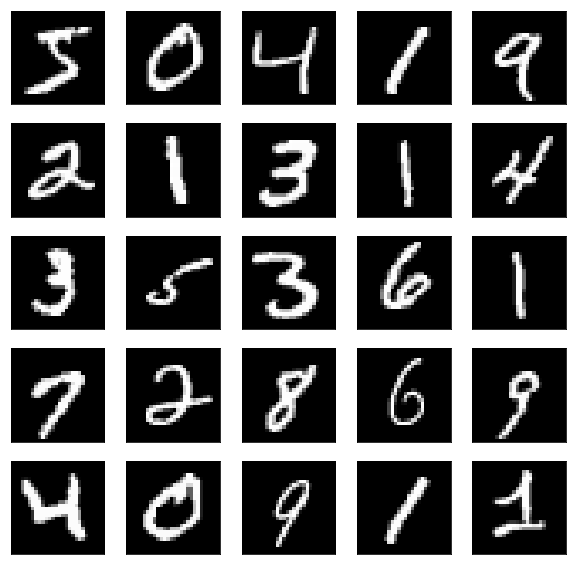

In [16]:
x_train, y_train, x_test, y_test, input_shape = load_data()

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i,ax in enumerate(axs.flatten()):
    training_image = x_train[i]
    # Note that training_image is an array with three dimensions; we want a 2D array
    training_image = training_image[:,:,0] 
    ax.imshow(training_image, cmap="gray", vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[])

We note that these images have a black background and very white digits.  Ours don't yet look like that.
Let's preprocess our digits in order to make them  similar to these!

Note that we still might have digits that are rotated; don't worry about that for the moment.

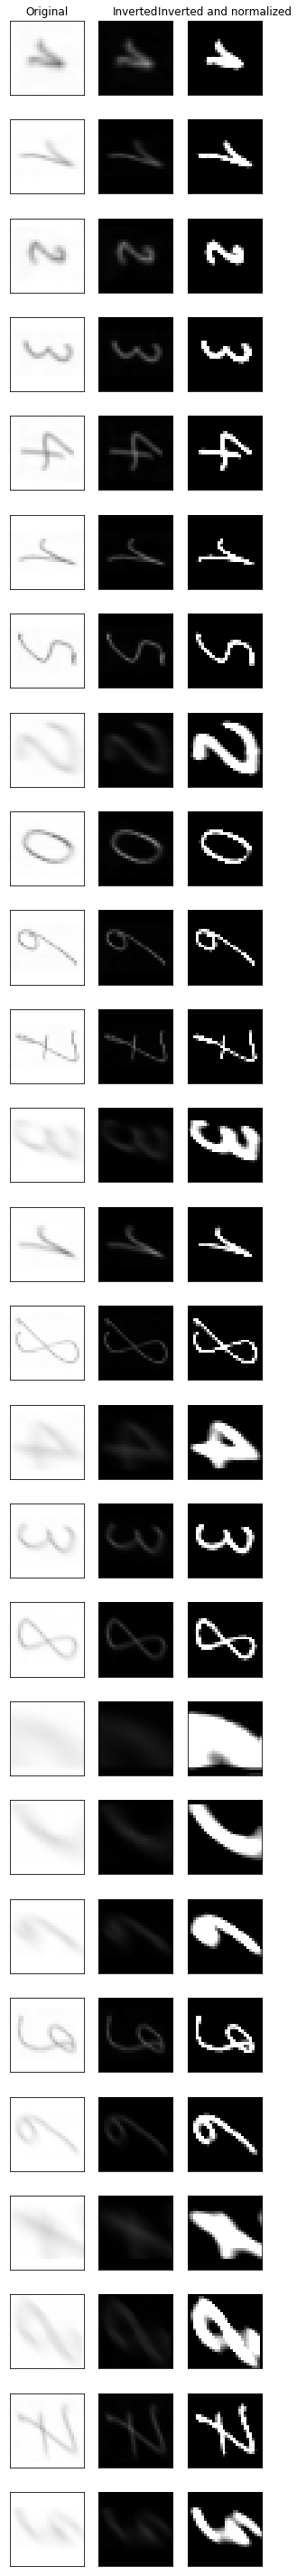

In [22]:
import scipy.interpolate
interpolator = scipy.interpolate.interp1d([0,0.2,0.4,1.0],[0,0,1,1])

def invert(digit):
    return 1.0-digit

def preprocess(digit):
    digit = invert(digit)
    digit = digit/np.max(digit) # Make sure that the maximum value is 1.0!
    digit = np.clip(digit, a_min=0.0, a_max=1.0)
    digit = interpolator(digit)
    digit = digit
    return digit

fig, axs = plt.subplots(nrows=len(digits), ncols=3, figsize=(5, 2*len(digits)))
for i,digit in enumerate(digits):
    axs[i,0].imshow(digit, cmap="gray", vmin=0, vmax=1)
    axs[i,1].imshow(invert(digit), cmap="gray", vmin=0, vmax=1)
    axs[i,2].imshow(preprocess(digit), cmap="gray", vmin=0, vmax=1)
for ax in axs.flatten():
    ax.set(xticks=[], yticks=[])
axs[0,0].set_title("Original")
axs[0,1].set_title("Inverted")
axs[0,2].set_title("Inverted and normalized");

## Apply the model to preprocessed digits and determine the most likely orientation of the sheet

Let's now apply the model to our preprocessed digits, in all 4 possible orientations of each.  For each digit and rotation, we print the probability that, according to our rotation classification model, that orientation is correct for our digit.

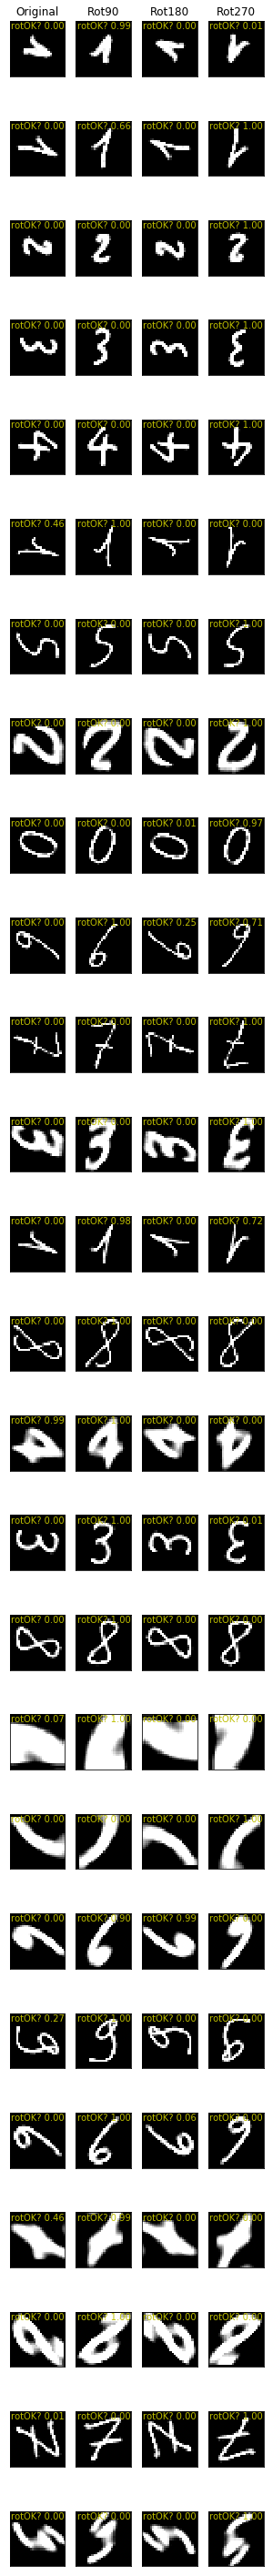

In [24]:
fig, axs = plt.subplots(nrows=len(digits), ncols=4, figsize=(5, 2*len(digits)))
rotOK = np.empty((len(digits), 4))
for i, digit in enumerate(digits):
    digitp = preprocess(digit)
    for rot in range(4):
        digitpr = np.rot90(digitp, k=rot)
        axs[i, rot].imshow(digitpr, cmap="gray", vmin=0, vmax=1)
        outputs = rotation_model.predict(digitpr[np.newaxis, :, :, np.newaxis])
        rotOK[i, rot] = outputs[0,0]
        axs[i, rot].text(
            0, 0, f"rotOK? {rotOK[i, rot]:.2f}", ha="left", va="top", color="y"
        )
for ax in axs.flatten():
    ax.set(xticks=[], yticks=[])
axs[0, 0].set_title("Original")
axs[0, 1].set_title("Rot90")
axs[0, 2].set_title("Rot180")
axs[0, 3].set_title("Rot270");

In [25]:
bestrot = np.argmax(np.mean(rotOK, axis=0))
print(f"Most likely rotation: {bestrot*90} degrees")

Most likely rotation: 90 degrees


## Rotate all digits accordingly and classify them

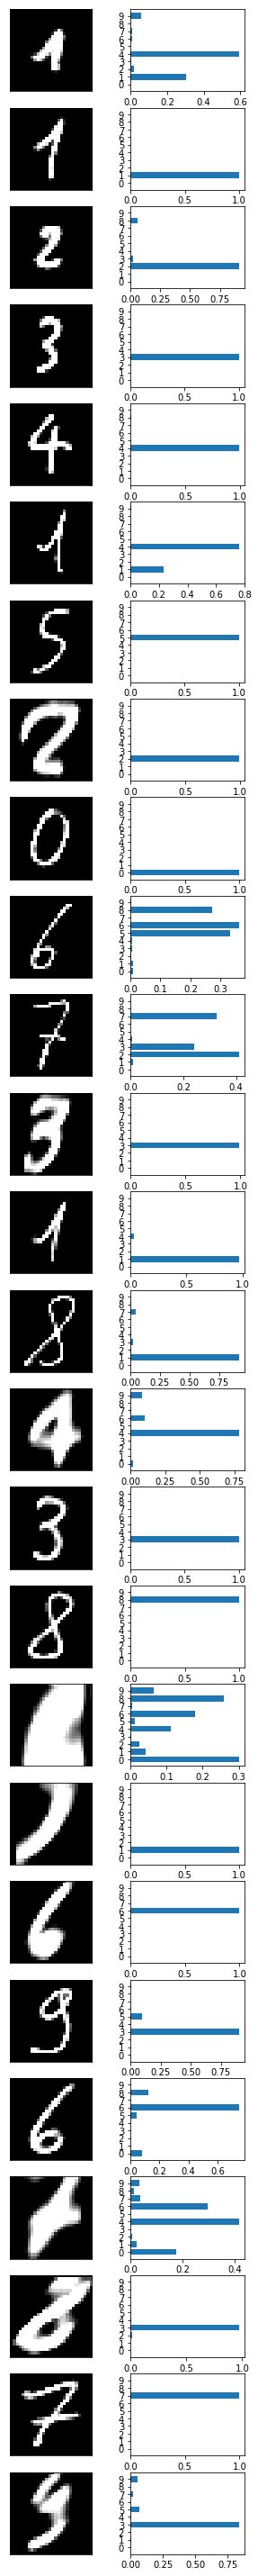

In [27]:
fig, axs = plt.subplots(nrows=len(digits), ncols=2, figsize=(5, 2*len(digits)))
rotOK = np.empty((len(digits), 4))
for i, digit in enumerate(digits):
    digitp = preprocess(digit)
    digitpr = np.rot90(digitp, k=bestrot)
    axs[i, 0].imshow(digitpr, cmap="gray", vmin=0, vmax=1)
    axs[i, 0].set(xticks=[], yticks=[])
    outputs = digit_model.predict(digitpr[np.newaxis, :, :, np.newaxis])
    axs[i, 1].barh(y=range(10), width=outputs[0,:])
    axs[i, 1].set(yticks=range(10))
    